## Activity 7.12

### Making a decision tree to predict COVID-19 positive patients

In [3]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, plot_confusion_matrix
from sklearn import tree

import pydot
from io import StringIO

from dm_tools import analyse_feature_importance, visualize_decision_tree

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

### Data loading and cleaning

#### Description of the dataset from Kaggle:

This dataset contains anonymized data from patients seen at the Hospital Israelita Albert Einstein, at São Paulo, Brazil, and who had samples collected to perform the SARS-CoV-2 RT-PCR and additional laboratory tests during a visit to the hospital.

All data were anonymized following the best international practices and recommendations. All clinical data were standardized to have a mean of zero and a unit standard deviation.

In [5]:
patients = pd.read_excel('data/dataset.xlsx')

In [6]:
patients.head()

,Patient ID,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,Basophils,Mean corpuscular hemoglobin (MCH),Eosinophils,Mean corpuscular volume (MCV),Monocytes,Red blood cell distribution width (RDW),Serum Glucose,Respiratory Syncytial Virus,Influenza A,Influenza B,Parainfluenza 1,CoronavirusNL63,Rhinovirus/Enterovirus,Mycoplasma pneumoniae,Coronavirus HKU1,Parainfluenza 3,Chlamydophila pneumoniae,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Parainfluenza 2,Neutrophils,Urea,Proteina C reativa mg/dL,Creatinine,Potassium,Sodium,"Influenza B, rapid test","Influenza A, rapid test",Alanine transaminase,Aspartate transaminase,Gamma-glutamyltransferase,Total Bilirubin,Direct Bilirubin,Indirect Bilirubin,Alkaline phosphatase,Ionized calcium,Strepto A,Magnesium,pCO2 (venous blood gas analysis),Hb saturation (venous blood gas analysis),Base excess (venous blood gas analysis),pO2 (venous blood gas analysis),Fio2 (venous blood gas analysis),Total CO2 (venous blood gas analysis),pH (venous blood gas analysis),HCO3 (venous blood gas analysis),Rods #,Segmented,Promyelocytes,Metamyelocytes,Myelocytes,Myeloblasts,Urine - Esterase,Urine - Aspect,Urine - pH,Urine - Hemoglobin,Urine - Bile pigments,Urine - Ketone Bodies,Urine - Nitrite,Urine - Density,Urine - Urobilinogen,Urine - Protein,Urine - Sugar,Urine - Leukocytes,Urine - Crystals,Urine - Red blood cells,Urine - Hyaline cylinders,Urine - Granular cylinders,Urine - Yeasts,Urine - Color,Partial thromboplastin time (PTT),Relationship (Patient/Normal),International normalized ratio (INR),Lactic Dehydrogenase,"Prothrombin time (PT), Activity",Vitamin B12,Creatine phosphokinase (CPK),Ferritin,Arterial Lactic Acid,Lipase dosage,D-Dimer,Albumin,Hb saturation (arterial blood gases),pCO2 (arterial blood gas analysis),Base excess (arterial blood gas analysis),pH (arterial blood gas analysis),Total CO2 (arterial blood gas analysis),HCO3 (arterial blood gas analysis),pO2 (arterial blood gas analysis),Arteiral Fio2,Phosphor,ctO2 (arterial blood gas analysis)
0,44477f75e8169d2,13,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,126e9dd13932f68,17,negative,0,0,0,0.236515,-0.02234,-0.517413,0.010677,0.102004,0.318366,-0.95079,-0.09461,-0.223767,-0.292269,1.482158,0.166192,0.357547,-0.625073,-0.140648,not_detected,not_detected,not_detected,not_detected,not_detected,detected,NaN,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,-0.619086,1.198059,-0.147895,2.089928,-0.305787,0.862512,negative,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,a46b4402a0e5696,8,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [7]:
patients.shape

(5644, 111)

Suppose the hospital is only interested in knowing more about the impact of 'regular blood test' and 'influenza rapid test' group variables. Therefore, your analysis should be focused on the variables of these two groups only in addition to 'Patient age quantile'. The target variable should be set to the 'SARS-Cov-2 exam result' variable.

1. Regular blood test: ['Proteina C reativa', 'Neutrophils', 'Mean platelet volume', 'Monocytes', 'Red blood cell distribution width', 'Red blood Cells', 'Platelets', 'Eosinophils', 'Basophils', 'Leukocytes', 'Mean corpuscular hemoglobin', 'Mean corpuscular volume', 'Mean corpuscular hemoglobin concentration ', 'Lymphocytes', 'Hemoglobin', 'Hematocrit'].
2. Influenza rapid test: ['Influenza B rapid test', 'Influenza A rapid test'].

In [8]:
target = ['SARS-Cov-2 exam result']
features =  ['Patient age quantile', 'Proteina C reativa mg/dL', 'Neutrophils', 'Mean platelet volume ', 'Monocytes', 'Red blood cell distribution width (RDW)', 'Red blood Cells',
             'Platelets', 'Eosinophils', 'Basophils', 'Leukocytes', 'Mean corpuscular hemoglobin (MCH)', 'Mean corpuscular volume (MCV)',
             'Mean corpuscular hemoglobin concentration\xa0(MCHC)', 'Lymphocytes', 'Hemoglobin', 'Hematocrit',
             'Influenza B, rapid test', 'Influenza A, rapid test']
all_covariates = target + features

In [9]:
# Limit the dataframe to only the target and features we are interested in

patients = patients[all_covariates]

In [10]:
patients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5644 entries, 0 to 5643
Data columns (total 20 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   SARS-Cov-2 exam result                            5644 non-null   object 
 1   Patient age quantile                              5644 non-null   int64  
 2   Proteina C reativa mg/dL                          506 non-null    float64
 3   Neutrophils                                       513 non-null    float64
 4   Mean platelet volume                              599 non-null    float64
 5   Monocytes                                         601 non-null    float64
 6   Red blood cell distribution width (RDW)           602 non-null    float64
 7   Red blood Cells                                   602 non-null    float64
 8   Platelets                                         602 non-null    float64
 9   Eosinophils        

What is the proportion of patients who are classified as COVID-19 positive? Would you require a smapling technique on this data?

In [11]:
positive = len(patients[patients['SARS-Cov-2 exam result'] == 'positive'])
pct = np.round((positive / len(patients)) * 100, 2)

print(f"{pct}% of {len(patients)} are COVID-19 positive.")
print(positive)

9.89% of 5644 are COVID-19 positive.
558


This is a maredly unbalance dataset with >90% of patients not having COVID. Random sampling may work for some predictive models, but for others a stratified sampling technique may be required.  

Most patients do not have regular blood tests of rapid influenza tests recorded. Given the hospital is particularly interested in patients based on these results we will drop patients who have not had a Full Blood Count (usually includes Hb and cell counts). We will use the feature 'Leukocytes' to do this.

In [12]:
patients = patients.dropna(subset=['Leukocytes'])
patients.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 602 entries, 1 to 5643
Data columns (total 20 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   SARS-Cov-2 exam result                            602 non-null    object 
 1   Patient age quantile                              602 non-null    int64  
 2   Proteina C reativa mg/dL                          502 non-null    float64
 3   Neutrophils                                       513 non-null    float64
 4   Mean platelet volume                              599 non-null    float64
 5   Monocytes                                         601 non-null    float64
 6   Red blood cell distribution width (RDW)           602 non-null    float64
 7   Red blood Cells                                   602 non-null    float64
 8   Platelets                                         602 non-null    float64
 9   Eosinophils         

Let us now deal with creating numerical representations of categorical variables and any nonsensical data.

In [13]:
patients['SARS-Cov-2 exam result'].value_counts()

negative    519
positive     83
Name: SARS-Cov-2 exam result, dtype: int64

In [14]:
patients['SARS-Cov-2 exam result'] = patients['SARS-Cov-2 exam result'].map({'negative':0, 'positive':1})

In [15]:
patients['Influenza B, rapid test'] = patients['Influenza B, rapid test'].map({'negative':0, 'positive':1})
patients['Influenza A, rapid test'] = patients['Influenza A, rapid test'].map({'negative':0, 'positive':1})

In [16]:
# Check all dtypes are now numeric

patients.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 602 entries, 1 to 5643
Data columns (total 20 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   SARS-Cov-2 exam result                            602 non-null    int64  
 1   Patient age quantile                              602 non-null    int64  
 2   Proteina C reativa mg/dL                          502 non-null    float64
 3   Neutrophils                                       513 non-null    float64
 4   Mean platelet volume                              599 non-null    float64
 5   Monocytes                                         601 non-null    float64
 6   Red blood cell distribution width (RDW)           602 non-null    float64
 7   Red blood Cells                                   602 non-null    float64
 8   Platelets                                         602 non-null    float64
 9   Eosinophils         

In [17]:
# Check for any non-sensical min/max/dsitributions

patients.describe()

,SARS-Cov-2 exam result,Patient age quantile,Proteina C reativa mg/dL,Neutrophils,Mean platelet volume,Monocytes,Red blood cell distribution width (RDW),Red blood Cells,Platelets,Eosinophils,Basophils,Leukocytes,Mean corpuscular hemoglobin (MCH),Mean corpuscular volume (MCV),Mean corpuscular hemoglobin concentration (MCHC),Lymphocytes,Hemoglobin,Hematocrit,"Influenza B, rapid test","Influenza A, rapid test"
count,602.000000,602.000000,502.000000,5.130000e+02,5.990000e+02,6.010000e+02,6.020000e+02,6.020000e+02,6.020000e+02,6.020000e+02,6.020000e+02,6.020000e+02,6.020000e+02,6.020000e+02,6.020000e+02,6.020000e+02,602.000000,602.000000,196.000000,196.000000
mean,0.137874,11.156146,0.003367,5.908361e-09,7.438142e-09,-3.220114e-09,1.020433e-08,8.424447e-09,-3.535004e-10,7.206147e-09,-6.633740e-09,6.215833e-09,-3.453010e-09,-4.155369e-09,1.014863e-09,-7.866736e-09,-0.000900,-0.001267,0.066327,0.035714
std,0.345054,5.710620,1.004205,1.000976e+00,1.000836e+00,1.000833e+00,1.000832e+00,1.000832e+00,1.000832e+00,1.000832e+00,1.000832e+00,1.000832e+00,1.000832e+00,1.000832e+00,1.000832e+00,1.000832e+00,1.001418,1.001178,0.249489,0.186052
min,0.000000,0.000000,-0.535362,-3.339775e+00,-2.457575e+00,-2.163721e+00,-1.598094e+00,-3.970608e+00,-2.552426e+00,-8.355077e-01,-1.140144e+00,-2.020303e+00,-5.937604e+00,-5.101581e+00,-5.431808e+00,-1.865070e+00,-4.345603,-4.501420,0.000000,0.000000
25%,0.000000,7.000000,-0.514995,-6.518655e-01,-6.624832e-01,-6.141920e-01,-6.250727e-01,-5.679496e-01,-6.053457e-01,-6.669502e-01,-5.292256e-01,-6.372547e-01,-5.013556e-01,-5.148128e-01,-5.524761e-01,-7.307069e-01,-0.586244,-0.518807,0.000000,0.000000
50%,0.000000,12.000000,-0.393291,-5.364196e-02,-1.015171e-01,-1.151911e-01,-1.827903e-01,1.385207e-02,-1.217160e-01,-3.298351e-01,-2.237665e-01,-2.128790e-01,1.259032e-01,6.604462e-02,-5.458523e-02,-1.426696e-02,0.040316,0.053407,0.000000,0.000000
75%,0.000000,16.000000,0.038884,6.838943e-01,6.838353e-01,4.888627e-01,3.479481e-01,6.661759e-01,5.314981e-01,3.443949e-01,3.871516e-01,4.542955e-01,5.963475e-01,6.268712e-01,6.424628e-01,5.976919e-01,0.729532,0.717175,0.000000,0.000000
max,1.000000,19.000000,8.026671,2.535929e+00,3.713052e+00,4.533397e+00,6.982184e+00,3.645706e+00,9.532034e+00,8.350876e+00,1.107822e+01,4.522042e+00,4.098546e+00,3.410980e+00,3.331071e+00,3.764100e+00,2.671868,2.662704,1.000000,1.000000


None of the lab values seem to conform to normal reference ranges, and most of them have negative values. They may have undergone some data transformation already. This makes it impossible to know if the values make sense. So, we'll just have to go with what we've got...
<br>
<br>
Next we need to deal with the remaining missing data. As we have already culled a significant portion of our dataset, it is reasonable to impute missing values.
<br>
CRP, Neutrophils, MPV, Monocytes and influenza tests have missing data.
<br>
<br>
For the laboratory values, we will impute the missing values with the mean of available data.
<br><br>
Finally, we need to deal with the missing influenza tests. For the purpose of this analysis, we are going to assume if patients were not tested for influenza, they did not have influenza.

In [18]:
patients['Proteina C reativa mg/dL'].fillna(np.mean(patients['Proteina C reativa mg/dL']), inplace=True)
patients['Monocytes'].fillna(np.mean(patients['Monocytes']), inplace=True)
patients['Mean platelet volume '].fillna(np.mean(patients['Mean platelet volume ']), inplace=True)
patients['Neutrophils'].fillna(np.mean(patients['Neutrophils']), inplace=True)

patients['Influenza B, rapid test'].fillna(0, inplace=True)
patients['Influenza A, rapid test'].fillna(0, inplace=True)

In [19]:
patients.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 602 entries, 1 to 5643
Data columns (total 20 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   SARS-Cov-2 exam result                            602 non-null    int64  
 1   Patient age quantile                              602 non-null    int64  
 2   Proteina C reativa mg/dL                          602 non-null    float64
 3   Neutrophils                                       602 non-null    float64
 4   Mean platelet volume                              602 non-null    float64
 5   Monocytes                                         602 non-null    float64
 6   Red blood cell distribution width (RDW)           602 non-null    float64
 7   Red blood Cells                                   602 non-null    float64
 8   Platelets                                         602 non-null    float64
 9   Eosinophils         

In [20]:
positive = len(patients[patients['SARS-Cov-2 exam result'] == 1])
pct = np.round((positive / len(patients)) * 100, 2)

print(f"{pct}% of {len(patients)} are COVID-19 positive.")

13.79% of 602 are COVID-19 positive.


The proportion of COVID-19 positive patients has increased slightly following the removal of patients missing FBCs. This may indicate that only patients who clinicians were more concerned about COVID-19 had laboratory tests ordered.

### Construction of decision tree models
#### Preparation of training and test sets
We need to split the dataset into train and test sets. We will stratify based on the target variable to ensure equal proportions of COVID positive patients exist in both train and test sets.

In [21]:
y = patients['SARS-Cov-2 exam result']
X = patients.drop(['SARS-Cov-2 exam result'], axis=1)

X_mat = X.to_numpy()

rs=42

X_train, X_test, y_train, y_test = train_test_split(X_mat, y, test_size=0.3, stratify=y, random_state=rs)

#### Decision tree with default settings

In [22]:
model_default = DecisionTreeClassifier(random_state=rs)
model_default.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

What is the classification accuracy of training and test datasets?

In [23]:
model_default = DecisionTreeClassifier(random_state=rs)
model_default.fit(X_train, y_train)

print("Train accuracy:", model_default.score(X_train, y_train))
print("Test accuracy:", model_default.score(X_test, y_test))

y_pred = model_default.predict(X_test)
print(classification_report(y_test, y_pred))

Train accuracy: 1.0
Test accuracy: 0.8121546961325967
              precision    recall  f1-score   support

           0       0.91      0.87      0.89       156
           1       0.36      0.48      0.41        25

    accuracy                           0.81       181
   macro avg       0.64      0.67      0.65       181
weighted avg       0.84      0.81      0.82       181



What is the size of thr tree (number of nodes and rules)?

In [24]:
nodes = model_default.tree_.node_count

print(f"The default decision tree classifier has {nodes} nodes.")

The default decision tree classifier has 57 nodes.


In [25]:
model_text = tree.export_text(model_default, feature_names=list(X.columns))

rule_count = 0

# Count the leafs - any linearised path through the tree is a rule and all rules end with a leaf
for line in model_text.split('\n'):
    if 'class' in line:
        rule_count += 1
        
print(f"The default decision tree classifier has {rule_count} rules.")

The default decision tree classifier has 29 rules.


Let's visualise the decision tree to answer the next question - Which variable is used for the first split?

In [26]:
visualize_decision_tree(model_default, X.columns, 'default_dt.png')

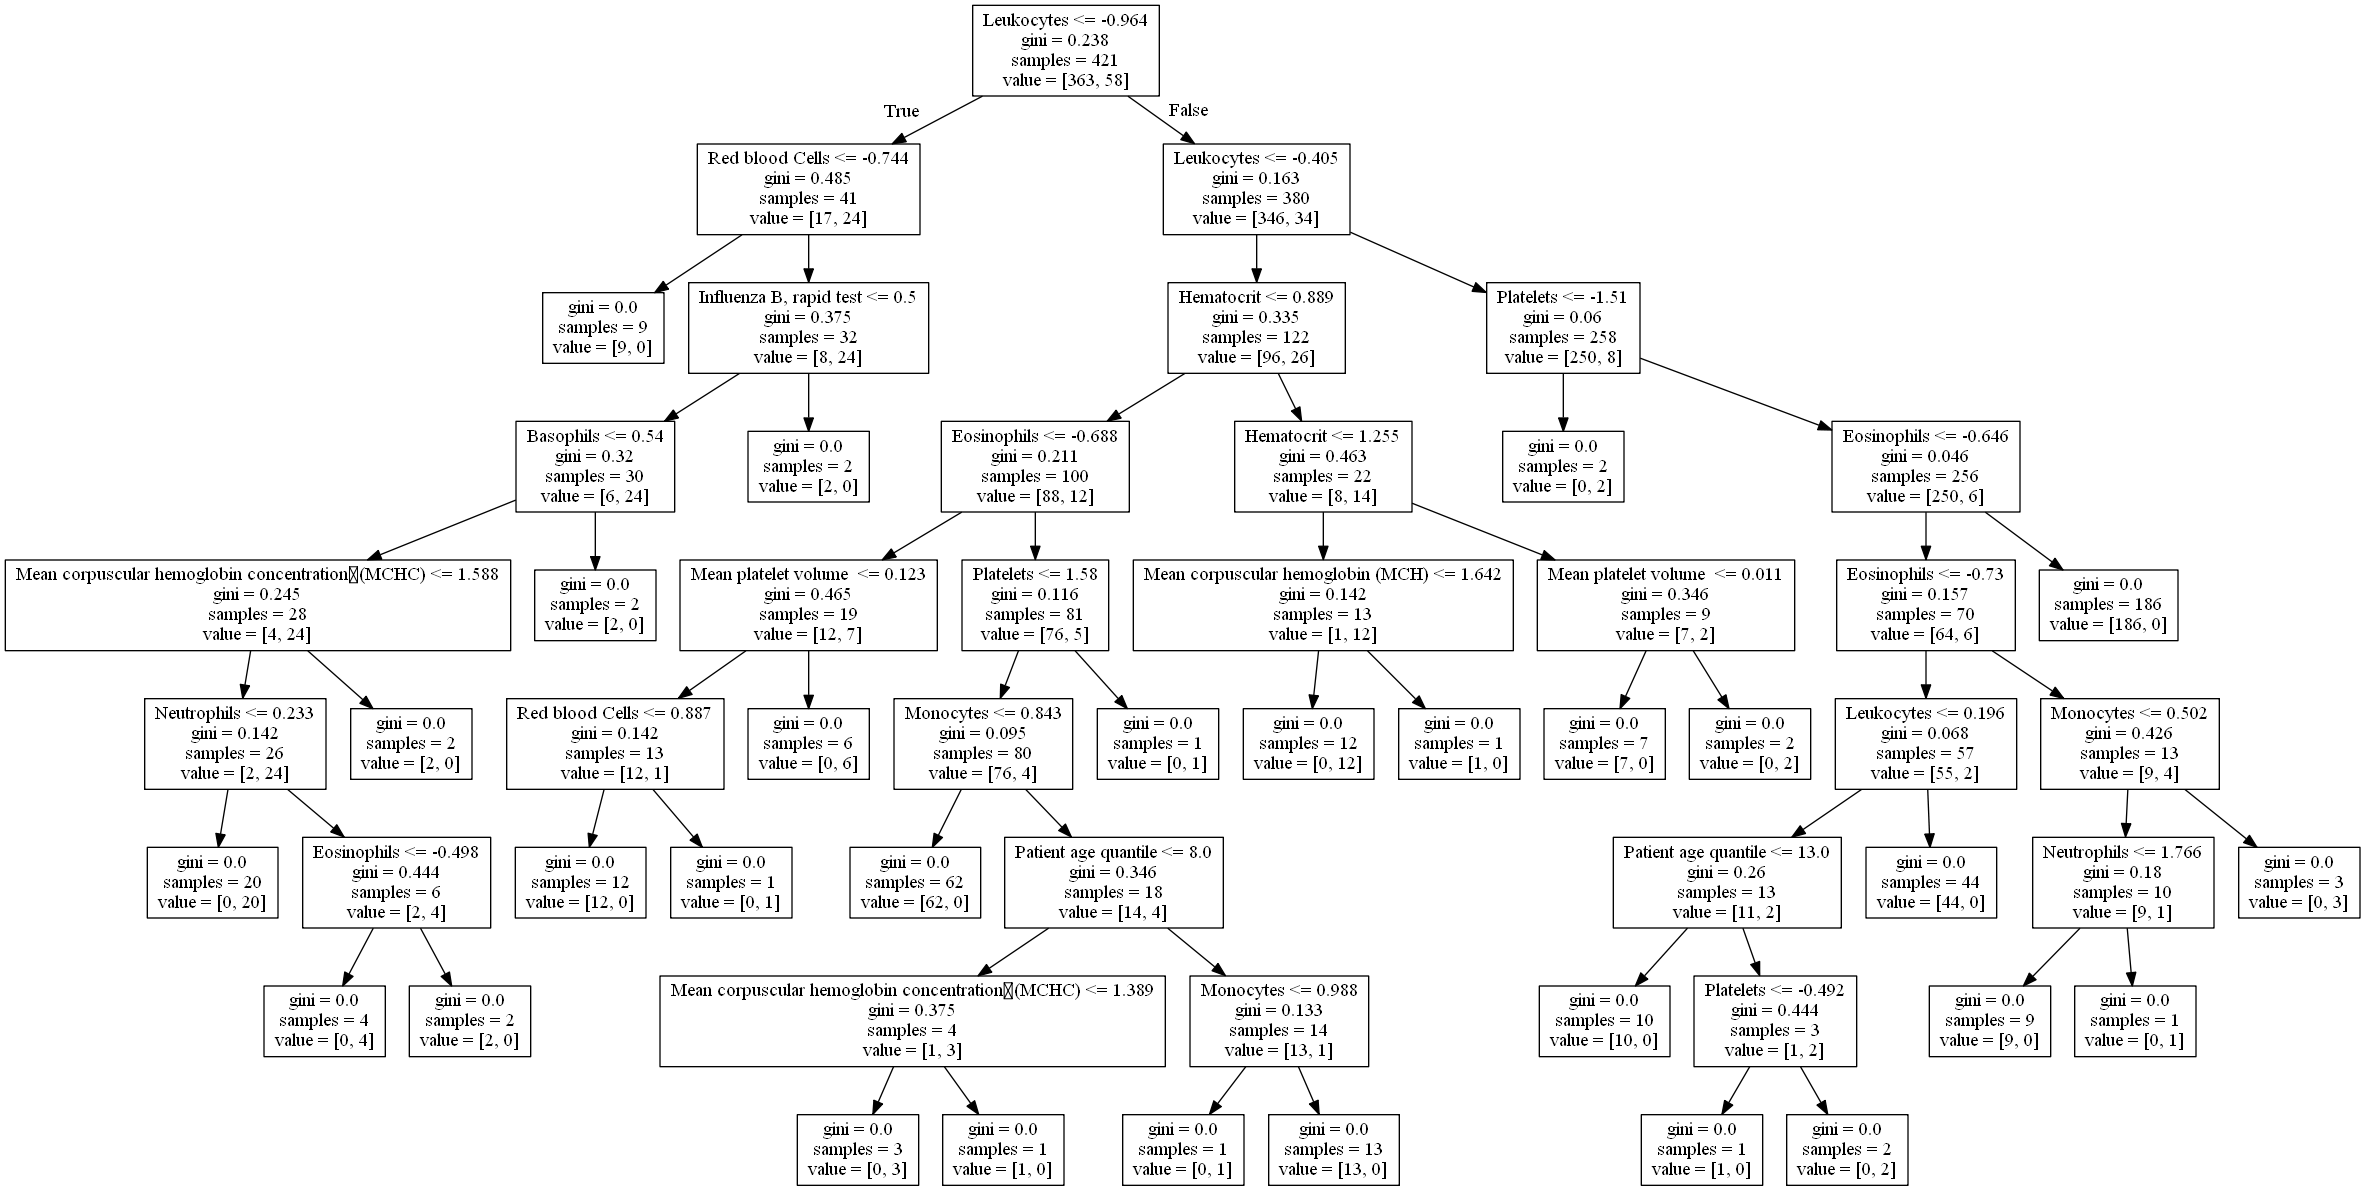
<br>
<br>
The Leukocytes feature is used for the first split.

What are the five important variables in building the tree?

In [27]:
analyse_feature_importance(model_default, X.columns, n_to_display=5)

Leukocytes : 0.24165096390913743
Hematocrit : 0.1483794826700423
Mean platelet volume  : 0.10105142311048927
Red blood Cells : 0.09746740758285986
Eosinophils : 0.07880987118108221


What parameters have been used in building the tree?

In [28]:
model_default.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

#### Optimal Decision Tree tuned with GridSearchCV

In [31]:
params = {'criterion': ['gini', 'entropy'],
          'max_depth': range(1, 10),
          'min_samples_leaf': range(0, 100, 5)[1:]}

cv_1 = GridSearchCV(param_grid=params, estimator=DecisionTreeClassifier(random_state=rs),return_train_score=True, cv=10)
cv_1.fit(X_train, y_train)

print(cv_1.best_params_)

cv_1.fit(X_train, y_train)

print("Train accuracy:", cv_1.score(X_train, y_train))
print("Test accuracy:", cv_1.score(X_test, y_test))

y_pred_cv = cv_1.predict(X_test)
print(classification_report(y_test, y_pred_cv))

{'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 5}
Train accuracy: 0.9477434679334917
Test accuracy: 0.8397790055248618
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       156
           1       0.41      0.36      0.38        25

    accuracy                           0.84       181
   macro avg       0.65      0.64      0.65       181
weighted avg       0.83      0.84      0.84       181



What is the size of the tree (number of nodes and rules)?

In [30]:
nodes = cv_1.best_estimator_.tree_.node_count

print(f"The optimal decision tree classifier has {nodes} nodes.")

The optimal decision tree classifier has 41 nodes.


In [32]:
model_text_cv = tree.export_text(cv_1.best_estimator_, feature_names=list(X.columns))

rule_count = 0

# Count the leafs - any linearised path through the tree is a rule and all rules end with a leaf
for line in model_text_cv.split('\n'):
    if 'class' in line:
        rule_count += 1
        
print(f"The optimal decision tree classifier has {rule_count} rules.")

The optimal decision tree classifier has 21 rules.


What variable is used for the first split?

In [32]:
print(model_text_cv)

|--- Leukocytes <= -0.96
|   |--- Red blood Cells <= -0.74
|   |   |--- class: 0
|   |--- Red blood Cells >  -0.74
|   |   |--- Basophils <= 0.23
|   |   |   |--- Mean corpuscular hemoglobin (MCH) <= -0.16
|   |   |   |   |--- class: 1
|   |   |   |--- Mean corpuscular hemoglobin (MCH) >  -0.16
|   |   |   |   |--- class: 1
|   |   |--- Basophils >  0.23
|   |   |   |--- Leukocytes <= -1.09
|   |   |   |   |--- class: 1
|   |   |   |--- Leukocytes >  -1.09
|   |   |   |   |--- class: 0
|--- Leukocytes >  -0.96
|   |--- Leukocytes <= -0.40
|   |   |--- Hematocrit <= 0.89
|   |   |   |--- Eosinophils <= -0.69
|   |   |   |   |--- Mean platelet volume  <= 0.12
|   |   |   |   |   |--- Patient age quantile <= 9.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- Patient age quantile >  9.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- Mean platelet volume  >  0.12
|   |   |   |   |   |--- class: 1
|   |   |   |--- Eosinophils >  -0.69
|   |   |   |   |--- Lympho

In [33]:
visualize_decision_tree(cv_1.best_estimator_, X.columns, 'dt_optimal.png')

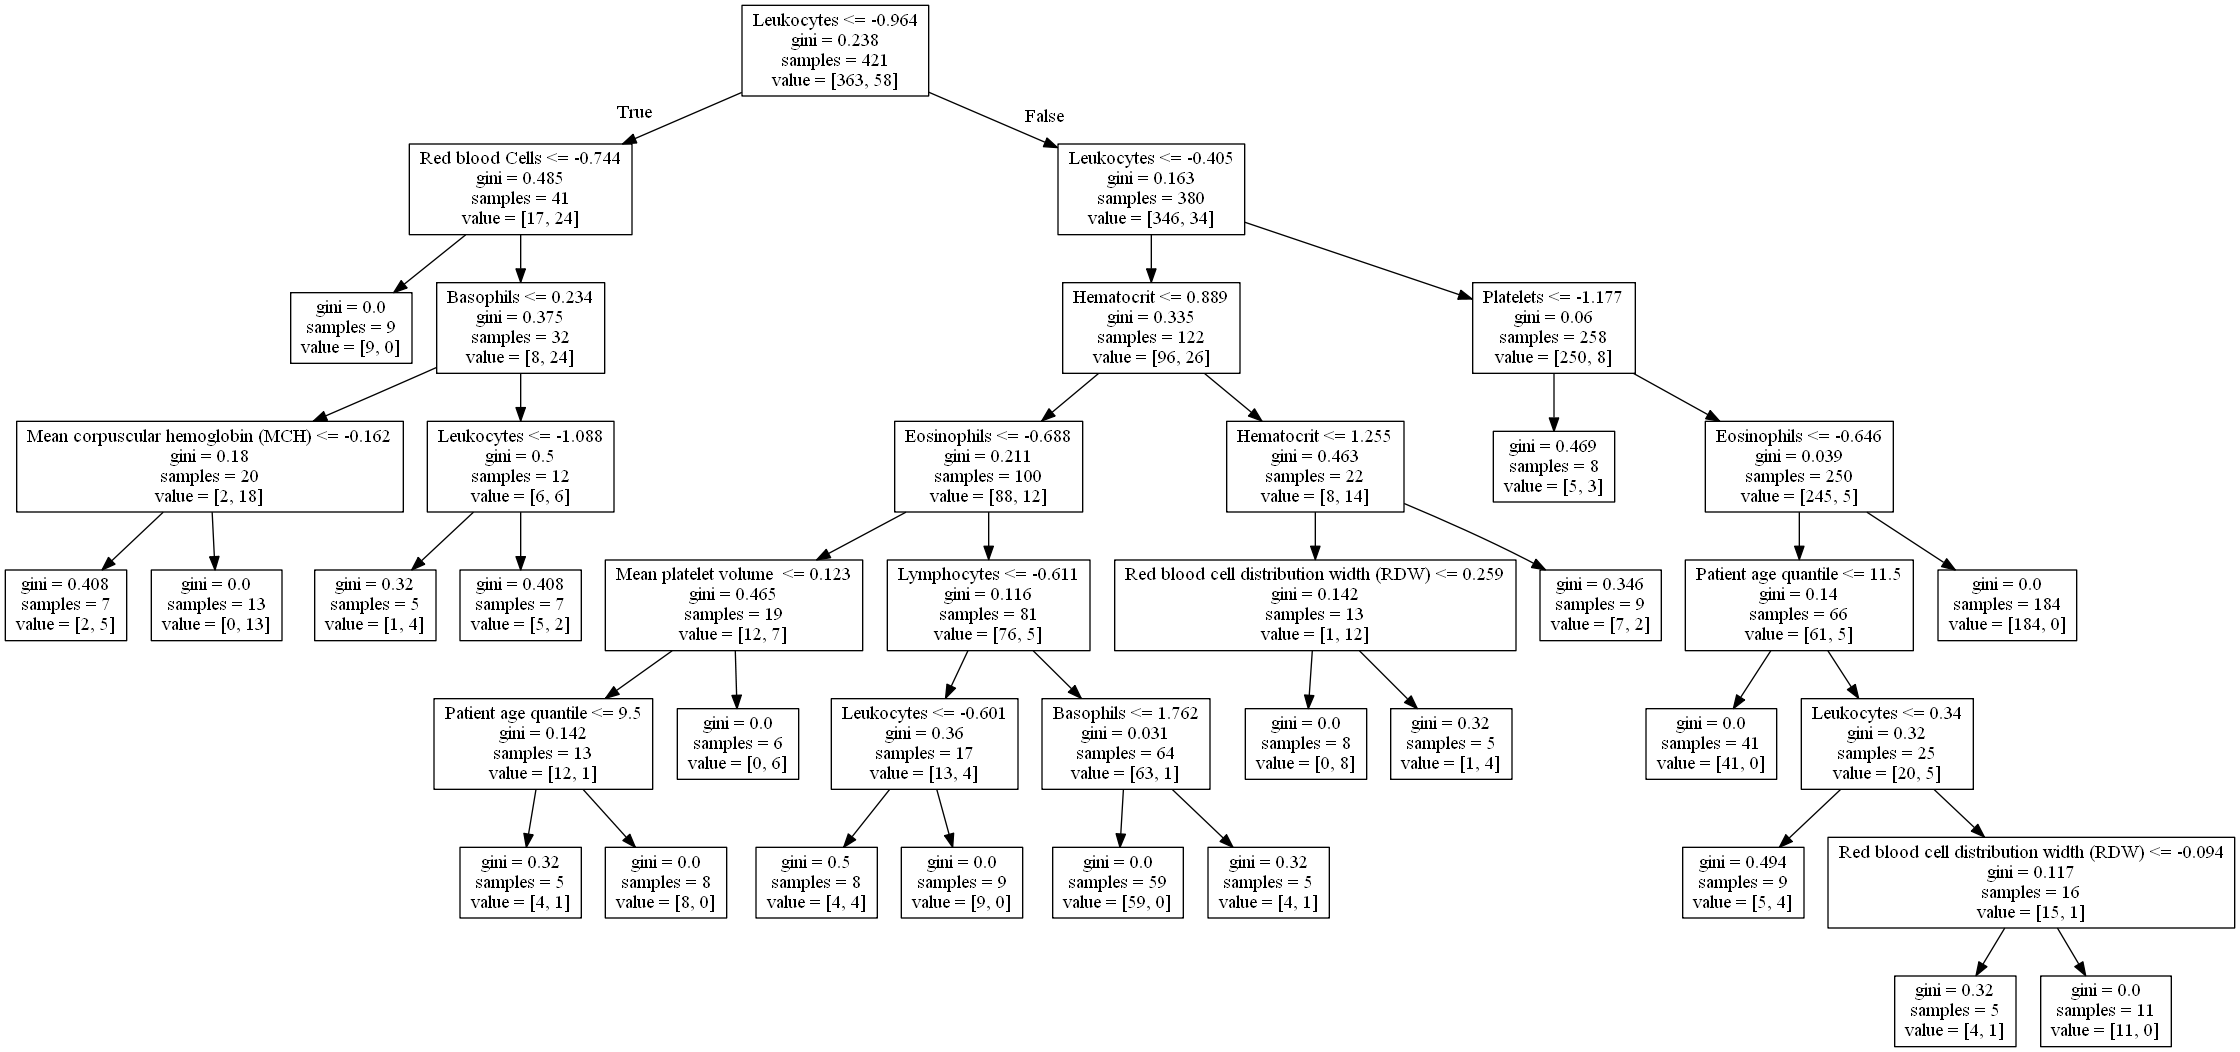

Leukocytes still used for the first split.
<br><br>
What are the five important variables in building the tree?

In [34]:
analyse_feature_importance(cv_1.best_estimator_, X.columns, n_to_display=5)

Leukocytes : 0.4089585552868492
Hematocrit : 0.20902736875407826
Red blood Cells : 0.11130327318449142
Mean platelet volume  : 0.09853569124025148
Eosinophils : 0.04863091889081274


Report if you see any evidence of model overfitting.
<br><br>
Accuracy in the training set remains significantly higher than in the test set. Although it is better than the default model, there is still some evidence of overfitting in the optimal model found by GridSearchCV.
<br><br>
What are the parameters used?

In [35]:
cv_1.best_estimator_.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 7,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

#### What is the difference you see between these two decision tree models (refer to the size of the trees—number of nodes and rules)? How do they compare performance-wise? Produce the ROC curve for both DTs. Explain why those changes may have happened.

In [36]:
y_pred_proba_default = model_default.predict_proba(X_test)
y_pred_proba_cv = cv_1.best_estimator_.predict_proba(X_test)

roc_index_default = roc_auc_score(y_test, y_pred_proba_default[:, 1])
roc_index_cv = roc_auc_score(y_test, y_pred_proba_cv[:, 1])

print("ROC index on test for DT_default:", roc_index_default)
print("ROC index on test for DT_cv:", roc_index_cv)

ROC index on test for DT_default: 0.6726923076923077
ROC index on test for DT_cv: 0.7617948717948718


In [37]:
# Compute FPR, TPR and thresholds to plot the ROC curve
fpr_default, tpr_default, thresholds_default = roc_curve(y_test, y_pred_proba_default[:,1])
fpr_cv, tpr_cv, thresholds_cv = roc_curve(y_test, y_pred_proba_cv[:,1])

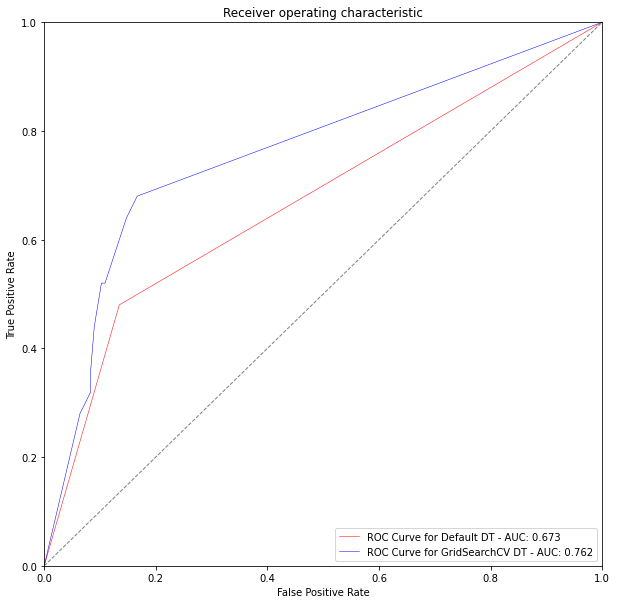

In [40]:
fig, ax = plt.subplots(figsize=(10,10))

ax.plot(fpr_default, tpr_default, label='ROC Curve for Default DT - AUC: {:.3f}'.format(roc_index_default), color='red', lw=0.5)
ax.plot(fpr_cv, tpr_cv, label='ROC Curve for GridSearchCV DT - AUC: {:.3f}'.format(roc_index_cv), color='blue', lw=0.5)

# Reference line
ax.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')

ax.set_xlim(0,1)
ax.set_ylim(0,1)

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic')
ax.legend(loc="lower right")

plt.savefig('dt_roc_curve.jpg')

plt.show()



The optimal model obtained via GridSearchCV is less complex with fewer nodes and fewer rules. It still retains the same 5 most important features.The optimal model achieves better performance on the test (unseen) data as demonstrated by improved accuracy, improved ROC curve characteristics and improved ROC-AUC.The unrestricted (default) decision tree was able to overfit to the training data and therefore generalised poorly to the unseen test dataset, reducing its performance. The simpler optimal model was able to learn the more general features of the training data and subsequently perform better on the unseen test set.  

#### From the better model, can you identify which patients could potentially be 'COVID-19 Positive'? Can you provide general characteristics of those patients?

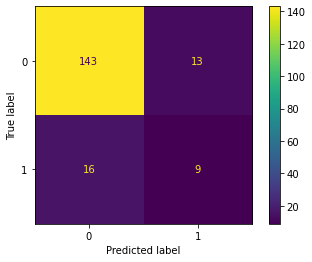

In [39]:
plot_confusion_matrix(cv_1.best_estimator_, X_test, y_test)

Despite an overall accuracy of 84% (and acceptable precision and recall), prediction of COVID-19 positive patients is lacking even in the better model. Only 9 of 25 COVID positive patients in the test set were correctly labelled. 
<br><br>
Generally, patients who were predicted to be COVID-19 positive had lower leukocyte counts, lower basophils, higher mean corpuscular haemoglobin and lower red blood cell distribution width.

In [44]:
# Save the best DT

best_dt = cv_1

import pickle
with open('best_DT.pickle', 'wb') as f:
    pickle.dump([best_dt,roc_index_cv, fpr_cv, tpr_cv], f)